In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('/content/seattle-weather.csv')

In [42]:
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [43]:
df.isnull().sum()

,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


In [44]:
df.duplicated().sum()

np.int64(0)

In [45]:
#coulmn Open converted into numpy array
training_set = df.iloc[:,2:3].values
training_set

array([[12.8],
       [10.6],
       [11.7],
       ...,
       [ 7.2],
       [ 5.6],
       [ 5.6]])

In [46]:
len(training_set)

1461

In [47]:
def df_to_XY(df,window_size=10):
 X_train=[]
 y_train=[]

 for i in range(10,len(training_set)):
    X_train.append(training_set[i-10:i,0])
    y_train.append(training_set[i,0])

 X_train, y_train = np.array(X_train), np.array(y_train)
 return X_train, y_train

In [48]:
WINDOW = 10
X,y = df_to_XY(df,WINDOW)
print(len(X),len(y))
X_train = X[:800]
y_train = y[:800]
X_val = X[800:1000]
y_val = y[800:1000]
X_test = X[1000:]
x_test = y[1000:]

1451 1451


In [49]:
#Reshaping(To add new dimensions)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
X_val = np.reshape(X_val,(X_val.shape[0],X_val.shape[1],1))
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))


In [50]:
#Building the RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [51]:
regressor = Sequential()

In [52]:
#Addinf the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50, return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

#Output layer
regressor.add(Dense(units=1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [53]:
#Compiling
regressor.compile(optimizer='adam',loss='mean_squared_error')

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


In [57]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam, RMSprop
import tensorflow as tf

# Function that builds the model with tunable hyperparameters
def build_model(hp):
    model = regressor  # use the architecture you already defined above

    # Choose optimizer (adam or rmsprop) and tune learning rate
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))  # log scale between 0.0001 and 0.01
    else:
        optimizer = RMSprop(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log'))

    # Tune batch size
    batch_size = hp.Choice('batch_size', [32, 64, 128])

    # Compile the model with chosen optimizer and fixed loss function
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Define the tuner (Random Search to try multiple hyperparameter combinations)
tuner = kt.RandomSearch(
    build_model,                 # model building function
    objective='val_loss',        # optimize for lowest validation loss
    max_trials=5,                # number of different hyperparameter sets to try
    executions_per_trial=1,      # how many times to train each set (for consistency)
    directory='lstm_tuning',     # folder to save results
    project_name='stock_price'   # project name for logs
)

# Start hyperparameter search
tuner.search(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,  # train each trial for 50 epochs
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]  # stop early if no improvement
)

# Get the best set of hyperparameters found
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Rebuild the model with best hyperparameters
regressor = tuner.hypermodel.build(best_hps)

# Train the final model with optimal hyperparameters
history = regressor.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,  # final training (can increase since EarlyStopping prevents overfitting)
    batch_size=best_hps.get('batch_size'),  # use best batch size
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Reloading Tuner from lstm_tuning/stock_price/tuner0.json
Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 255.6975 - val_loss: 301.3581
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 132.3589 - val_loss: 188.3669
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 86.1000 - val_loss: 149.3815
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 68.8816 - val_loss: 131.7430
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 61.3784 - val_loss: 119.4149
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 60.8943 - val_loss: 109.5974
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 62.4930 - val_loss: 102.1716
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 56.7383 - val_loss: 96.0971
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 55.9003 - val_loss: 91.5046
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 56.8731 - val_loss: 87.4887
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 55.

In [58]:
his = pd.DataFrame(history.history)

In [59]:
his.head()

,loss,val_loss
0,229.613403,301.358063
1,113.778465,188.366852
2,79.828903,149.381454
3,67.804420,131.742981
4,63.086235,119.414909


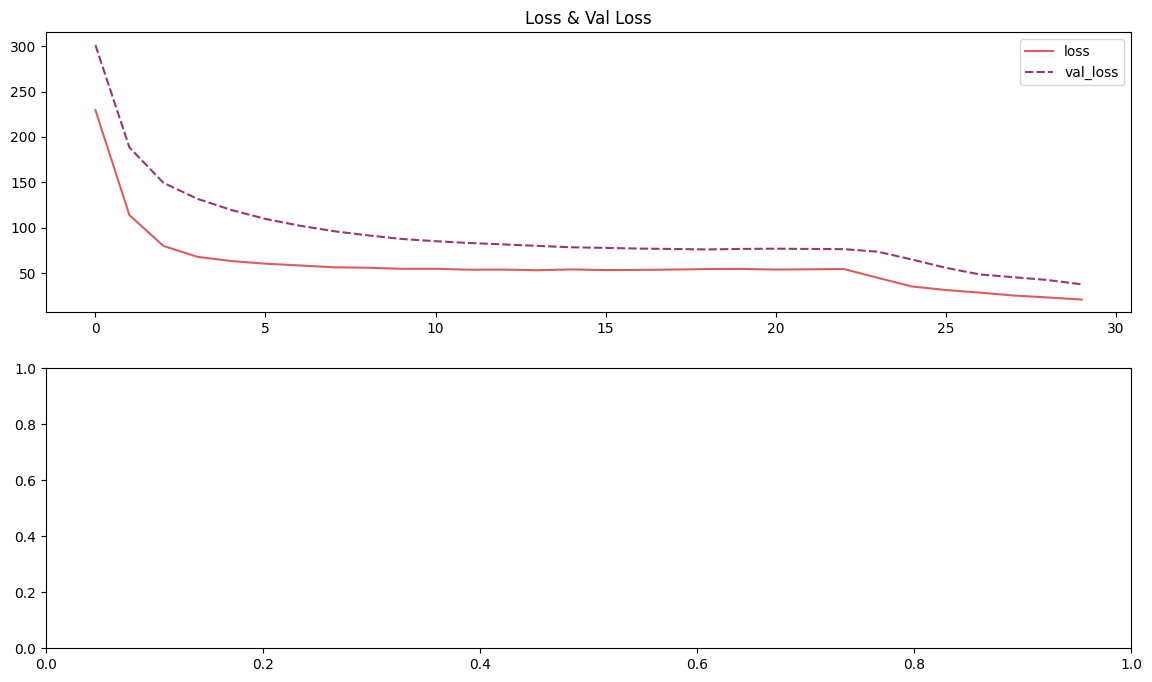

In [60]:
import seaborn as sns
his.columns
history_loss = his[['loss', 'val_loss']]


fig,axes = plt.subplots(2,1,figsize=(14,8))
plt.subplot(2,1,1)
plt.title("Loss & Val Loss")
sns.lineplot(history_loss,palette="flare");



In [61]:
train_pred = regressor.predict(X_train).flatten()
val_pred = regressor.predict(X_val).flatten()
test_pred = regressor.predict(X_test).flatten()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


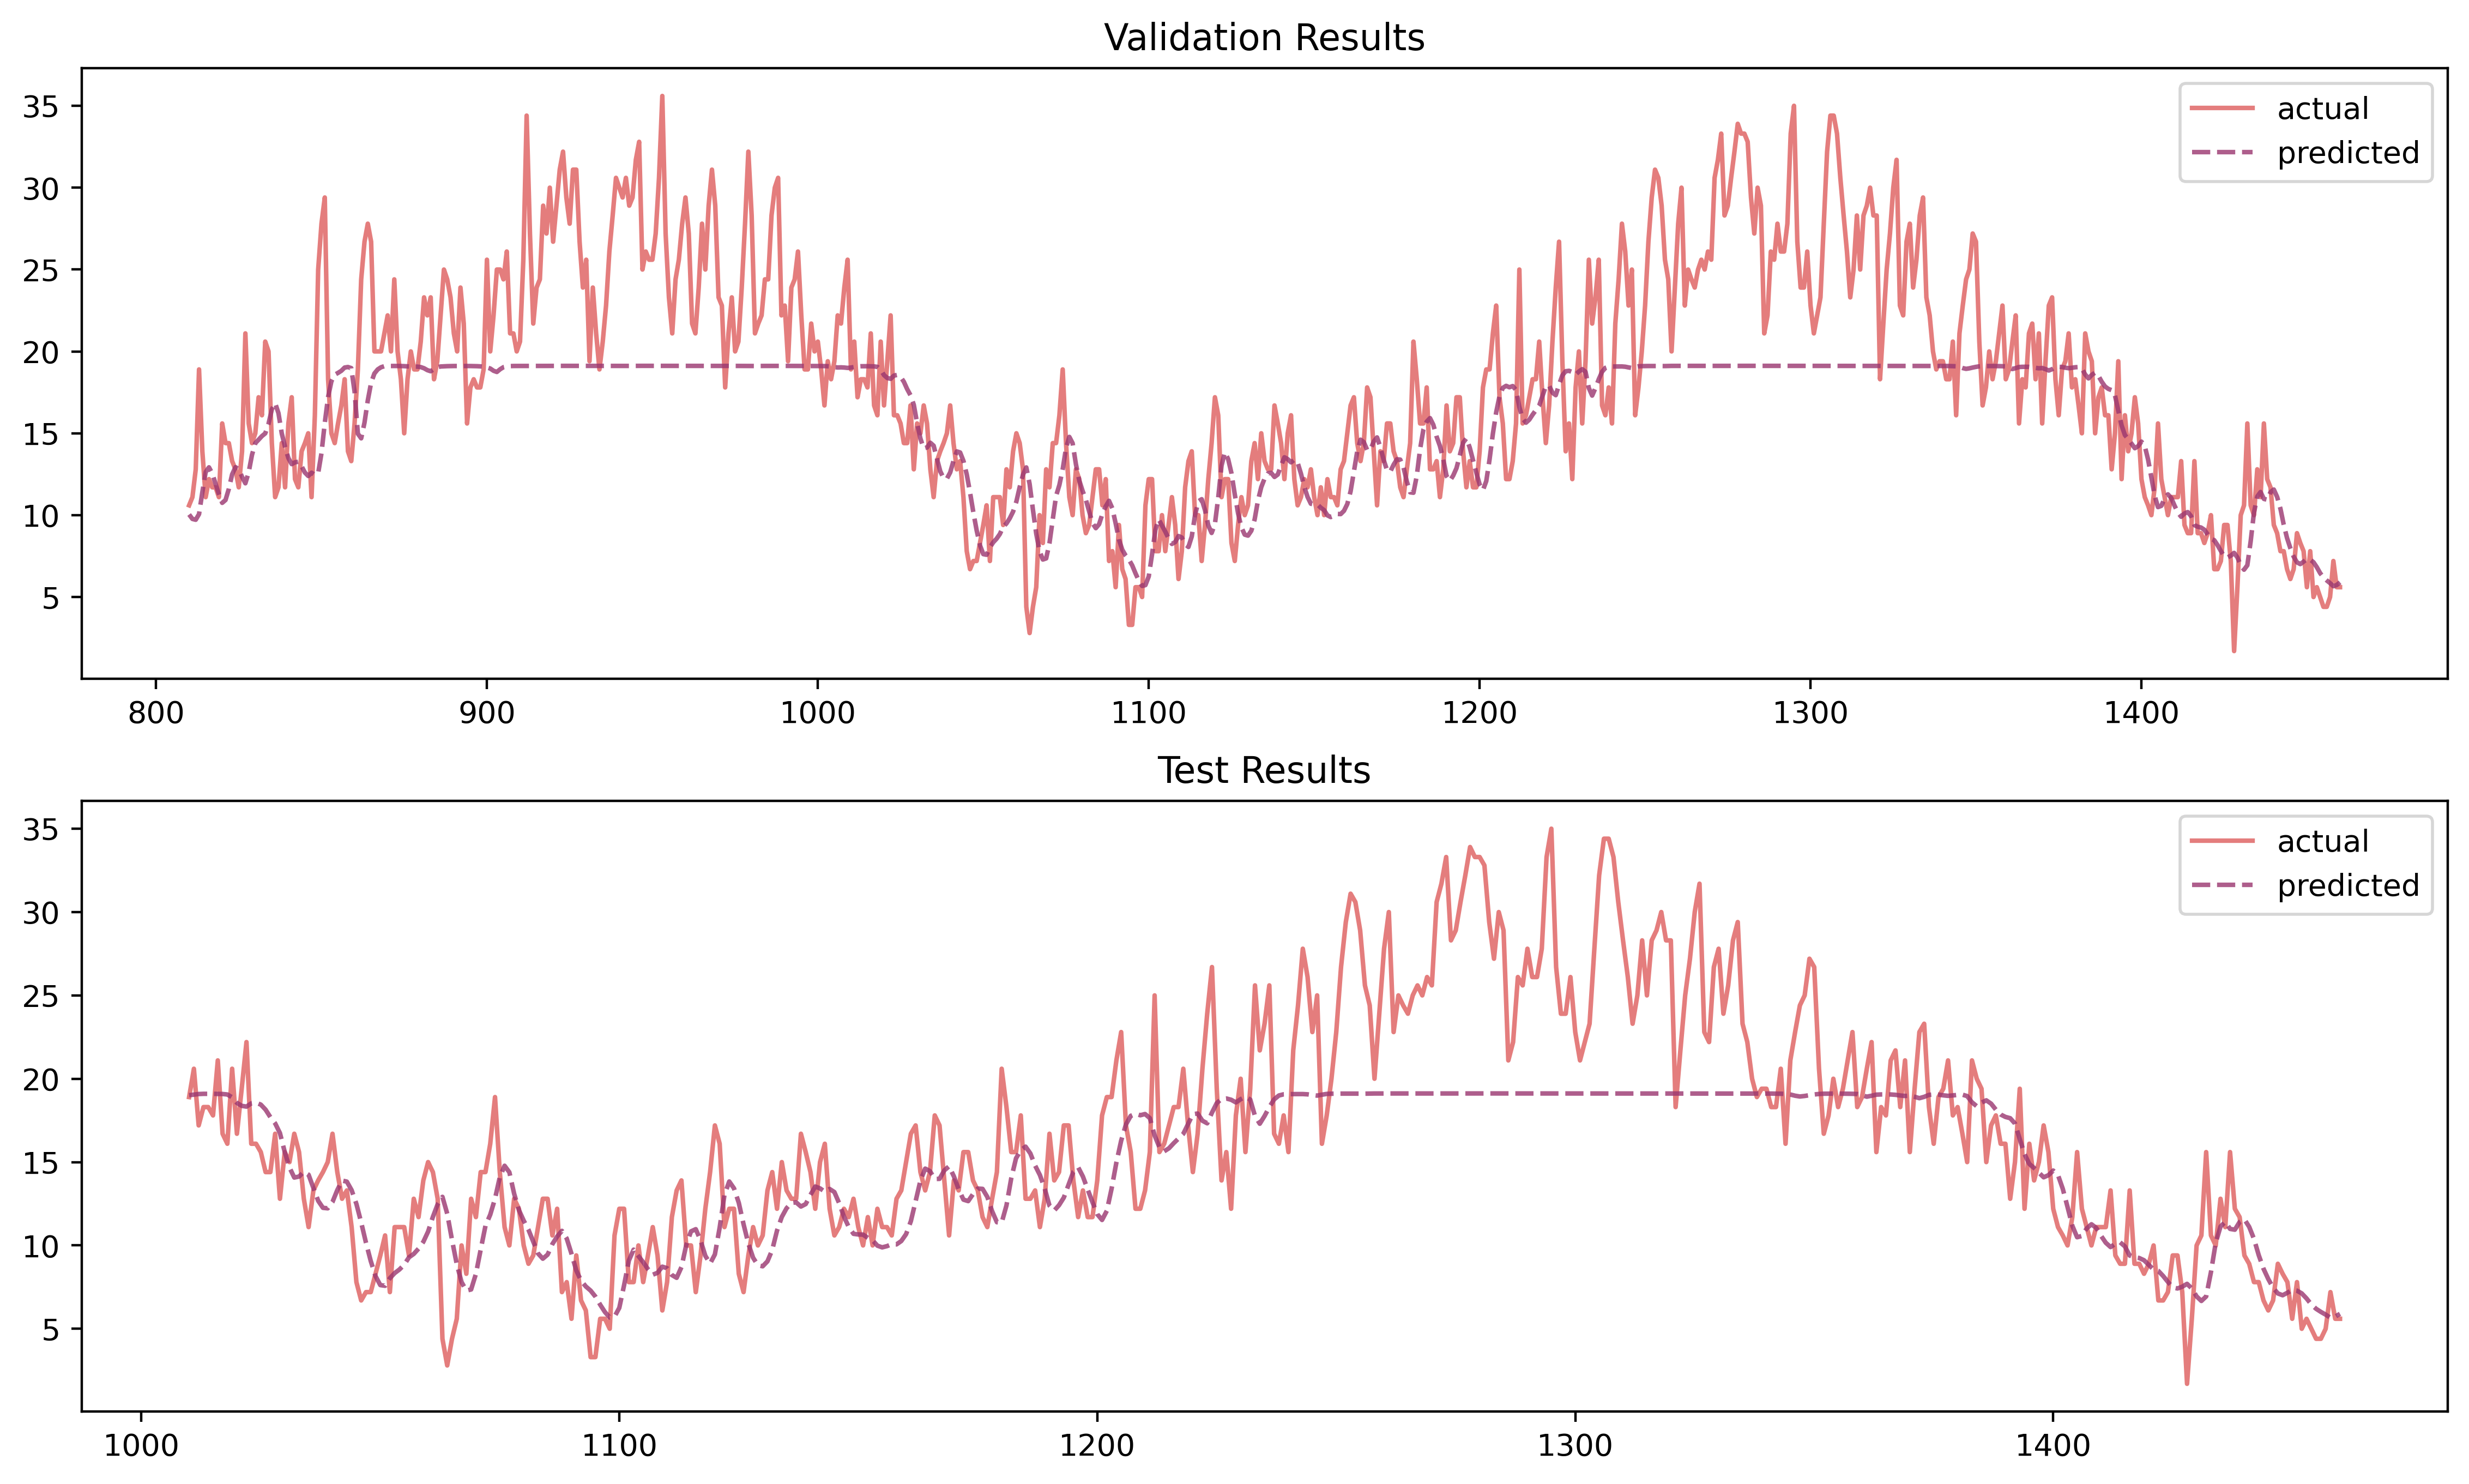

In [62]:
pred = np.concatenate([train_pred,val_pred,test_pred])
df_pred = pd.DataFrame(df["temp_max"].copy())
df_pred.columns=["actual"]
df_pred = df_pred[WINDOW:]
df_pred["predicted"] = pred

fig,axes = plt.subplots(2,1,figsize=(14,8),dpi=400)

plt.subplot(2,1,1)
plt.title("Validation Results")
sns.lineplot(df_pred[800:],alpha=0.8,palette="flare",linestyle=None);

plt.subplot(2,1,2)
plt.title("Test Results")
sns.lineplot(df_pred[1000:],alpha=0.8,palette="flare",linestyle=None);